# Seamounts Database tutorial

⚠️ If the generated code snippets do not work, please open an issue https://issues.hubocean.earth/form/f57a63fa-20d2-4268-af79-41eca8f374cd 🙏

In [ ]:
!pip install -U odp-sdk --quiet && pip list | grep odp
!pip install -U pydeck --quiet && pip list | grep pydeck

## 1.1 Setup ODP Client

In [ ]:
from odp.client import OdpClient # The SDK
import pandas as pd
import pydeck as pdk
from helper_functions import convert_geometry_field, wkt_to_edges

### 1.1.2 Geometric Plot Helper

In [ ]:
# loading a simple function to make a nice map display of points
def simple_pydeck_plot(geojson_lists, size=1, lat=0, lon=0, zoom=2):
    colors = [(3, 255, 209), (255, 216, 11), (157, 89, 244), (254, 119, 76)]  # Cyan, Yellow, Purple, Orange
    layers = []
    for i, geojson_list in enumerate(geojson_lists):
        layer = pdk.Layer("GeoJsonLayer", data=convert_geometry_field(geojson_list), lineWidthMinPixels=size, pointRadiusMinPixels=size, pickable=True, get_line_color=colors[i % len(colors)], get_fill_color=colors[i % len(colors)],)
        layers.append(layer)
    r = pdk.Deck(layers=layers, initial_view_state=(pdk.ViewState(latitude=lat, longitude=lon, zoom=zoom)), map_provider="mapbox", map_style='mapbox://styles/oceandatafoundation/clwg6xklg00an01pcgmeufjxq', api_keys={'mapbox': 'pk.eyJ1Ijoib2NlYW5kYXRhZm91bmRhdGlvbiIsImEiOiJjazk5bGxpNWkwYWU1M2Vya3hkcHh4czdrIn0.yf7kIiPfDNE7KP9_9wTN6A'})
    return r

In [ ]:
client = OdpClient()

### 2.1 Fetch Metadata from Catalog
- Option 1) via API calls to the catalog
- Option 2) getting UUID from the landing page:
https://app.hubocean.earth/catalog/dataset/1e3401d4-9630-40cd-a9cf-d875cb310449-YessonEtAl2019-SeamountBases-V2
https://app.hubocean.earth/catalog/dataset/1e3401d4-9630-40cd-a9cf-d875cb310449-YessonEtAl2019-Seamounts-V2
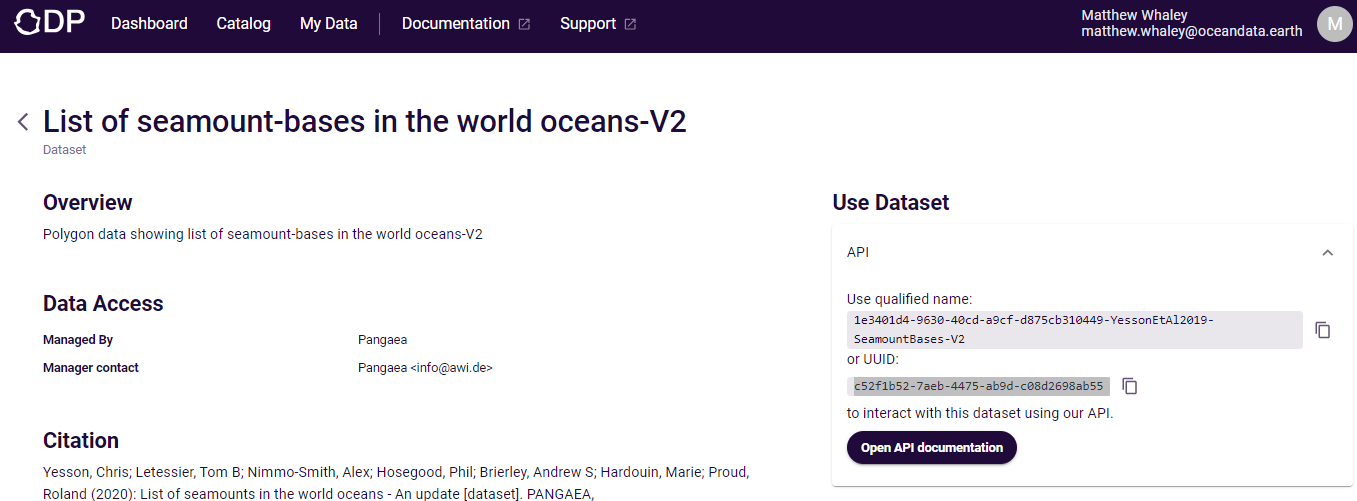

In [ ]:
## Request the dataset from the catalog using the UUID:
seamountpoint_dataset_id = '69360a03-c7a9-492a-adbe-5107d734ef72'
SeamountPoint = client.catalog_v2.get_dataset_by_id(seamountpoint_dataset_id)
## Verify the name of the dataset requested
SeamountPoint.name

In [ ]:
seamountbases_dataset_id = '8de642cc-03d9-4538-a6d4-8260e49df597'
SeamountBases = client.catalog_v2.get_dataset_by_id(seamountbases_dataset_id)
SeamountBases.name


### 2.2 Fetch data from the tabular v2

In [ ]:
SeamountPoint_dataset = client.table_v2(seamountpoint_dataset_id)
pages = list(SeamountPoint_dataset.select().pages())
SeamountPoint_data = [row for page in pages for row in page]


In [ ]:
SeamountBases_dataset = client.table_v2(seamountbases_dataset_id)
pages = list(SeamountBases_dataset.select().pages())
SeamountBases_data = [row for page in pages for row in page]

## 3.1 Visualize data

In [ ]:
SeamountBases_data[0]

### 3.1.1 Plot datapoints from query on a map

In [ ]:
# The coordinates of the data overlaps, so we plot about the first half of the SeamountPoint and the second half of the SeamountBases
simple_pydeck_plot([SeamountPoint_data[:15000],SeamountBases_data[15000:]], lat=55, lon=7, zoom=1)

## 4.1 Inspect data
### 4.1.1 Option 1): work with list of datapoints

In [ ]:
#inspecting the fifth item of the list (numbering starts from 0)
SeamountPoint_data[4:5]

### 4.1.2 Option 2): convert from the list to a pandas dataframe

In [ ]:
pd.DataFrame(SeamountPoint_data).head()

### 4.1.3 Option 3): use 'select().dataframes()' function of the SDK

In [ ]:
SeamountPoint_df = pd.concat(SeamountPoint_dataset.select().dataframes(), ignore_index=True)
SeamountPoint_df.head()

## 4.1 Test a geospatial query of some points

### 4.1.1 Create geospatial query

In [ ]:
from shapely.geometry import box, LineString, mapping
import shapely.wkt as wkt

bbox_lat_min = 56
bbox_lat_max = 80
bbox_lon_min = -22
bbox_lon_max = 12

geospatial_query = box(
    bbox_lon_min, bbox_lat_min,
    bbox_lon_max, bbox_lat_max
).wkt
bbox_list = wkt_to_edges(geospatial_query)

### 4.2.1 Query data with the geospatial query

In [ ]:
pages = SeamountPoint_dataset.select(f"geometry within '{geospatial_query}'").pages()
SeamountPoint_subset = [row for page in pages for row in page]

### 4.3.1 Plot the filtered data and bounding box

In [ ]:
simple_pydeck_plot([SeamountPoint_subset, bbox_list], size=2, lat=75, lon=-5, zoom=2)